# STYLE-ALIGNED WITH REFERENCE IMAGE

In [1]:
# Clone the repository
!git clone https://github.com/alessioborgi/StyleAligned_MultiReference-MultiModal.git

# Change directory to the cloned repository
%cd StyleAligned_MultiReference-MultiModal
%ls

# Set up Git configuration
# !git config --global user.name "Alessio Borgi"
# !git config --global user.email "alessioborgi3@gmail.com"

!git config --global user.name "Name Surname"
!git config --global user.email "email@gmail.com"

# Stage the changes
#!git add .

# Commit the changes
#!git commit -m "Added some content to your-file.txt"

# Push the changes (replace 'your-token' with your actual personal access token)
#!git push origin main

Cloning into 'StyleAlignedDiffModels'...
remote: Enumerating objects: 1645, done.
remote: Counting objects: 100% (508/508), done.
remote: Compressing objects: 100% (371/371), done.
remote: Total 1645 (delta 144), reused 490 (delta 130), pack-reused 1137 (from 1)
Receiving objects: 100% (1645/1645), 1.06 GiB | 17.11 MiB/s, done.
Resolving deltas: 100% (721/721), done.
Updating files: 100% (317/317), done.
/content/StyleAlignedDiffModels
 audio/
 imgs/
 LICENSE
 music/
 README.md
 requirements.txt
 src/
 StyleAligned_ControlNet.ipynb
 StyleAligned_Explanation.ipynb
 StyleAligned_Focused_Attention_Explanation.ipynb
 StyleAligned_Metrics.ipynb
'StyleAligned_MultiReference copy.ipynb'
 StyleAligned_MultiReference.ipynb
 StyleAligned_MultiReference_Slerp.ipynb
 StyleAligned_MultiScale_AdaIN_Explanation.ipynb
 StyleAligned_Prompts.ipynb
'StyleAligned_Ref&Content(Audio).ipynb'
'StyleAligned_Ref&Content(Audio+Music).ipynb'
'StyleAligned_Ref&Content(Img+Audio).ipynb'
'StyleAligned_Ref&Content(Im

In [2]:
# Install the required packages
!pip install -r requirements.txt > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.13 requires numpy<2,>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.13 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pandas-stubs 2.1.4.231227 requires numpy>=1.26.0; python_version < "3.13", but you have numpy 1.23.5 which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 2.2.2 which is incompatible.


In [3]:
from __future__ import annotations
import cv2
import copy
import torch
import einops
import random
import mediapy
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
from typing import Any
from typing import Callable
from dataclasses import dataclass
from diffusers.utils import load_image
from torch.nn import functional as nnf
from diffusers.models import attention_processor
from diffusers.image_processor import PipelineImageInput
from transformers import DPTImageProcessor, DPTForDepthEstimation
from diffusers.utils.torch_utils import is_compiled_module, is_torch_version
from diffusers import StableDiffusionXLPipeline, DDIMScheduler, ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL

from src.Handler import Handler
from src.StyleAlignedArgs import StyleAlignedArgs
from src.Tokenization_and_Embedding import prompt_tokenizazion_and_embedding, embeddings_ensemble, embeddings_ensemble_with_neg_conditioning
from src.Encode_Image import image_encoding
from src.Diffusion import Generate_Noise_Prediction, Denoising_next_step, DDIM_Process, extract_latent_and_inversion
from src.MultiReference_Diffusion import DDIM_Inversion_Process

# Create Alias for torch.tensor to increase readability.
T = torch.tensor
TN = T

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


#### Model Load

In [4]:
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)
if torch.cuda.is_available():
    torch.cuda.manual_seed(10)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
# Create a DDIMScheduler object with specific parameters
scheduler = DDIMScheduler(
    beta_start=0.00085,            # Starting value of beta for the noise schedule
    beta_end=0.012,                # Ending value of beta for the noise schedule
    beta_schedule="scaled_linear", # Type of beta schedule to use, here it is scaled linear
    clip_sample=False,             # Whether to clip the samples to a certain range
    set_alpha_to_one=False         # Whether to set alpha to one
)

# Load the Stable Diffusion XL Reference_Pipeline with a pretrained model
Reference_Pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  # Model name or path
    torch_dtype=torch.float16,                   # Data type for PyTorch tensors
    variant="fp16",                              # Variant of the model, here it is fp16 (16-bit floating point)
    use_safetensors=True,                        # Whether to use safe tensors
    scheduler=scheduler                          # Use the scheduler defined above
).to("cuda")                                     # Move the pipeline to the CUDA device (GPU)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
### MULTI-REFERENCE ###
# Set the Blending Weights we want to take into account (must sum to 1 !).
blending_weights = [0.5, 0.5]

# Set the Normal/Famous StyleAlignment Scaling
normal_famous_scaling = ["n", "f"]    # List containing the styles' classification of the reference images: "n" for normal and "f" for famous ones.

# 1) Medieval Painting
# Set the source style, prompt and path.
src1_style = "medieval painting"
src1_prompt = f'Man laying in a bed, {src1_style}.'
reference_image1_path = './imgs/medieval-bed.jpeg'

# 2) Cubism Painting
src2_style = "cubism painting"
src2_prompt = f'Two men smoking water pipe, {src2_style}.'
reference_image2_path = './imgs/Picasso_Smoking_Water_Pipe.jpeg'

# 2) Kid's Drawing
#src2_style = "kid's drawing"
#src2_prompt = f'An hill town in a sunny day, {src2_style}.'
#reference_image2_path = './imgs/kid_drawing.jpeg'

# 1) Mario Bros
# Set the source style, prompt and path.
#src1_style = "Macro"
#src1_prompt = f'Super Mario Bros standing, {src1_style}.'
#reference_image1_path = './imgs/supermario.jpg'


# Initialize combined style and prompt based on blending weights
combined_style = ""
blended_prompt = ""

# Adjust combined_style and blended_prompt based on the blending_weights
if blending_weights[0] > 0:
    combined_style += src1_style
    blended_prompt += src1_prompt.split(",")[0]

if blending_weights[1] > 0:
    if combined_style:
        combined_style += " and "
        blended_prompt += ", "
    combined_style += src2_style
    blended_prompt += src2_prompt.split(",")[0]

# 2) Cubism Painting
#reference_style = "cubism painting"
#reference_prompt = f'Two men smoking water pipe, {reference_style}.
#reference_image_path2 = './imgs/Picasso_Smoking_Water_Pipe.jpeg'

# Setting the number of inference steps in the Diffusion Inversion Process.
num_inference_steps = 50

# Setting the Guidance Scale for the Diffusion Inversion Process.
guidance_scale = 10.0

Reference Image 1 for Style Alignment

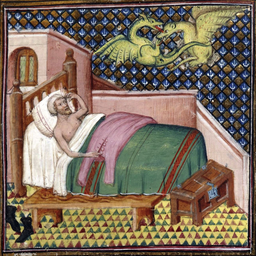

Reference Image 2 for Style Alignment

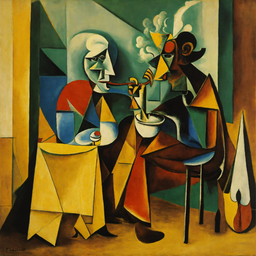

In [7]:
# Load the reference image 1 and resize it to 1024x1024 pixels.
ref_image_1 = np.array(load_image(reference_image1_path).resize((1024, 1024)))

# Load the reference image 2 and resize it to 1024x1024 pixels.
ref_image_2 = np.array(load_image(reference_image2_path).resize((1024, 1024)))

# Put the reference images in a list.
ref_images = list([ref_image_1, ref_image_2])

for (i, ref_image) in enumerate(ref_images):
    # Display the output image.
    mediapy.show_image(ref_image, title=f"Reference Image {i+1} for Style Alignment", height=256)


In [8]:
# Defining a type alias for the Diffusion Inversion Process type of callable.
Diff_Inversion_Process_Callback = Callable[[StableDiffusionXLPipeline, int, T, dict[str, T]], dict[str, T]]

In [ ]:
# Set of prompts to generate images for. The first refers to the Reference Image. The other to generate images.
prompts = [
    blended_prompt,
    "A lighthouse with sea in the background",
    "A snowman in the desert",
    "A space rocket which is departing",
    #"A robot which is playing football",
    #"A scarecrow in a wheat field",
    #"A mountain landscape",
    #"A treasure box in a cave",
    #"A hot air baloon with a sunset background",
    #"A castle with a flowery landscape",
]

# Append the reference style to each of subsequent prompts for generating images with the same Style.
for i in range(1, len(prompts)):
    prompts[i] = f'{prompts[i]}, {combined_style}.'

# Configure the StyleAligned Handler using the StyleAlignedArgs.
handler = Handler(Reference_Pipeline)

In [ ]:
# Execute the Diffusion Inversion Process to map the reference image to its latent representation.
DDIM_inv_result = DDIM_Inversion_Process(Reference_Pipeline, ref_images, blending_weights, blended_prompt, num_inference_steps, 2, normal_famous_scaling, handler)

# Extract the latent representation from the Diffusion Inversion Result that can be used to guide the generation of new images in the desired style.
latent_vector_ref_img, inversion_callback = extract_latent_and_inversion(DDIM_inv_result, offset=5)

# Create a Random Number Generator on the CPU.
rand_gen = torch.Generator(device='cpu').manual_seed(10)

# Generate the images using the latent representation of the reference image as guidance.
latents = torch.randn(len(prompts), 4, 128, 128,                            # Random Latent Vectors shape
                      device='cpu',                                         # Latent Vectors on CPU.
                      generator=rand_gen,                                   # Random Number Generator.
                      dtype=Reference_Pipeline.unet.dtype,).to('cuda:0')    # Data Type of the Latent Vectors (same as required by the model's UNet).

# Set the first latent vector to the latent representation of the reference image extracted before.
latents[0] = latent_vector_ref_img

# Generate the images using the provided prompts and the latent vectors.
images_a = Reference_Pipeline(prompts,                                      # Prompts to generate images for.
                              latents=latents,                              # Latent Vectors to guide the generation of images.
                              callback_on_step_end=inversion_callback,      # Callback to update the latent vectors during the generation process.
                              num_inference_steps=num_inference_steps,      # Number of Inference Steps to generate the images.
                              guidance_scale=guidance_scale).images         # Guidance Scale to control the influence of the latent vectors on the generated images.

# Display the generated images.
handler.remove()
mediapy.show_images(images_a, titles=[p[:-(len(combined_style) + 3)] for p in prompts])

In [11]:
import tensorflow as tf
import torch

def clear_gpu_memory():
    # Clear TensorFlow GPU memory
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()

    # Clear PyTorch GPU memory
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    print("GPU memory cleared.")

# Execute the function to clear GPU memory
clear_gpu_memory()


GPU memory cleared.
